# Plots the average energy of flashes of GLM
This jupyter notebook shows how to make a sub-region plot of the average energy of flashes of GLM.

Import the GOES package.

In [1]:
import GOES

Searchs GLM files between **2021-03-13 22:35:00** and **2021-03-13 22:40:00**.

In [2]:
flist=GOES.locate_files('/home/joao/Downloads/GOES-16/GLM/', 'OR_GLM*.nc',
                        '20210313-223500', '20210313-224000')

Reads the files.

In [3]:
ds = GOES.open_mfdataset(flist)

Prints the contents of the files.

In [4]:
print(ds)

<class 'GOES.processing.processing_data.open_mfdataset'>

number files: 15
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20210722235000_e20210722235205_c20210722235226.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20210722235200_e20210722235404_c20210722235426.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20210722235400_e20210722236004_c20210722236025.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20210722236000_e20210722236205_c20210722236225.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20210722236200_e20210722236404_c20210722236425.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20210722236400_e20210722237005_c20210722237023.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20210722237000_e20210722237204_c20210722237224.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20210722237200_e20210722237404_c20210722237428.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20210722237400_e20210722238004_c20210722238026.n

Set the map domain.

In [5]:
domain = [-86.0,-31.0,-40.0,15.0]

Gets longitude and latitude of flash product of GLM.

In [6]:
flash_lon = ds.variable('flash_lon')
flash_lat = ds.variable('flash_lat')

Gets energy of flash product of GLM.

In [7]:
flash_energy = ds.variable('flash_energy')

Since the flash energy has units of femtojoules (fJ; **1e-15** J), we are going to multiply it by **1e15** to facilitate its accumulation.

In [8]:
flash_energy.data = flash_energy.data*1e15

Gets time interval between first and last file.

In [9]:
time_bounds = ds.variable('product_time_bounds')
time_start = time_bounds.data[0,0]
time_end = time_bounds.data[-1,-1]

Creates a regular grid map with **2 km** of spatial resolution. In this example, we are using this spatial resolution, but you can change it according to your needs.

In [10]:
pix_resol = 2.0
gridmap_LonCor, gridmap_LatCor = GOES.create_gridmap(domain, PixResol=pix_resol)

Accumulate flash in the gridmap. Keep in mind that **gridmap_LonCor** and **gridmap_LatCor** are the corners of the pixels where the lightnings will accumulate. <br>
**Notice:** If your version of GOES package not have the **GOES.accumulate_in_gridmap** function or if you have problems to run the following code, then you must update the **GOES** package to the latest version.

In [11]:
dens = GOES.accumulate_in_gridmap(gridmap_LonCor, gridmap_LatCor, flash_lon, flash_lat)

    There are 4766 occurrences inside gridmap
    processing 100%


Accumulate flash energy in the gridmap.

In [12]:
energy_accum = GOES.accumulate_in_gridmap(gridmap_LonCor, gridmap_LatCor,
                                          flash_lon, flash_lat, parameter_value=flash_energy)

    There are 4766 occurrences inside gridmap
    processing 100%


Calculates the average flash energy.

In [13]:
import numpy as np

avg_energy = np.where(dens.data>0,energy_accum.data/dens.data,0.0)

Gets information about data.

In [14]:
sat = ds.attribute('platform_ID')[0]

Sets product name and its unit.

In [15]:
name = 'Average flash energy'
unit = '1e-15 J'

Creates a custom color palette using the [custom_color_palette](https://github.com/joaohenry23/custom_color_palette) package.

In [16]:
# import packages
import custom_color_palette as ccp
import matplotlib.pyplot as plt

# set the colors of the custom palette
pl1 = [['black'], [0,1]]
pl2 = [plt.cm.viridis, [1,100,200,300,400,500,750,1000,1500,2000], [[1,2,3,4,5,6,7,8,9,10,11,12,13],4,13]]

# pass parameters to the creates_palette module
cmap, cmticks, norm, bounds = ccp.creates_palette([pl1,pl2], extend='max')

# set ticks for colorbar
ticks = cmticks

Creates plot.

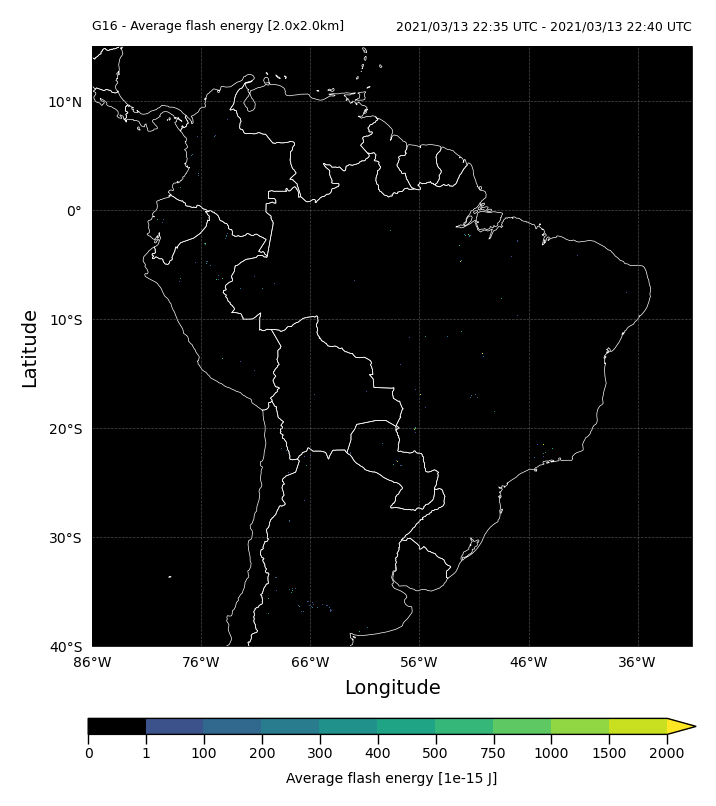

In [17]:
# import packages
import numpy as np
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# calculates the central longitude of the plot
lon_cen = 360.0+(domain[0]+domain[1])/2.0

# creates the figure
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(lon_cen))
#ax.outline_patch.set_linewidth(0.3)

# add the geographic boundaries
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='white', linewidth=0.25)

# plot the data
img = ax.pcolormesh(gridmap_LonCor.data, gridmap_LatCor.data, avg_energy, cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

# add the colorbar
cb = plt.colorbar(img, ticks=ticks, extend='max', orientation='horizontal',
                  cax=fig.add_axes([0.12, 0.05, 0.76, 0.02]))
cb.ax.tick_params(labelsize=5, labelcolor='black', width=0.5, direction='out', pad=1.0)
cb.set_label(label='{} [{}]'.format(name, unit), size=5, color='black', weight='normal')
cb.outline.set_linewidth(0.5)

# set the title
ax.set_title('{} - {} [{}x{}km]'.format(sat, name, pix_resol, pix_resol), fontsize=4.5, loc='left')
ax.set_title('{:%Y/%m/%d %H:%M UTC} - {:%Y/%m/%d %H:%M UTC}'.format(time_start, time_end),
             fontsize=4.5, loc='right')

# Sets X axis characteristics
dx = 10
xticks = np.arange(domain[0], domain[1]+dx, dx)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(dateline_direction_label=True))
ax.set_xlabel('Longitude', color='black', fontsize=7, labelpad=3.0)

# Sets Y axis characteristics
dy = 10
yticks = np.arange(domain[2], domain[3]+dy, dy)
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_ylabel('Latitude', color='black', fontsize=7, labelpad=3.0)

# Sets tick characteristics
ax.tick_params(left=True, right=True, bottom=True, top=True,
               labelleft=True, labelright=False, labelbottom=True, labeltop=False,
               length=0.0, width=0.05, labelsize=5.0, labelcolor='black')

# Sets grid characteristics
ax.gridlines(xlocs=xticks, ylocs=yticks, alpha=0.6, color='gray',
             draw_labels=False, linewidth=0.25, linestyle='--')

# set the map limits
ax.set_extent([domain[0]+360.0, domain[1]+360.0, domain[2], domain[3]], crs=ccrs.PlateCarree())

plt.show()